In [31]:
# BATS load in processed data and begin mode projection 
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 3750  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

In [41]:
# --- LOAD in initial processing results
# these include, raw profiles, velocity profiles, displacement profiles, background density profiles...
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2014_initial_processing.pkl', 'rb')
IP = pickle.load(pkl_file)
pkl_file.close()
ref_lon = IP['ref_lon']
ref_lat = IP['ref_lat']
grid = IP['depth']
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
profile_tags = IP['raw_profile_tags']
sa = IP['sa']
ct = IP['ct']
gamma = IP['gamma']
prof_lon = IP['prof_lon']
prof_lat = IP['prof_lat']
prof_time = IP['profile_time']
bckgrds = IP['background_indices']
bckgrds_key = IP['background key']
lon_lim = IP['lon_lim']
lat_lim = IP['lat_lim']

N2 = IP['N2_by_season_quad']
sa_avg = IP['bckgrd_sa']
ct_avg = IP['bckgrd_ct']
theta_avg = IP['bckgrd_theta']
gamma_avg = IP['bckgrd_gamma']
mw_time = IP['mw_time']
mw_lon = IP['mw_lon']
mw_lat = IP['mw_lat']
mw_ct = IP['mw_ct']
mw_sa = IP['mw_sa']
mw_gamma = IP['mw_gamma']
mw_eta_1 = IP['eta_1']
mw_eta_2 = IP['eta_2']
mw_eta_3 = IP['eta_3']
eta_ind_1 = IP['eta_per_1']
eta_ind_3 = IP['eta_per_3']

mw_time_good = IP['mw_time_good']
gamma_good = IP['mw_gamma_good']
mw_eta_1_good = IP['eta_1_good']
mw_eta_2_good = IP['eta_2_good']
mw_eta_3_good = IP['eta_3_good']
mw_v_good = IP['dg_v_good']
mw_v_e_good = IP['dg_v_e_good']
mw_v_n_good = IP['dg_v_n_good']
mw_prof_good = IP['mw_prof_good']
PE_per_prof = IP['PE_per_prof']

t_s = datetime.date.fromordinal(np.int(np.nanmin(prof_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(prof_time)))

In [33]:
np.nanmax(mw_time) - np.nanmin(mw_time)

63.133531308267266

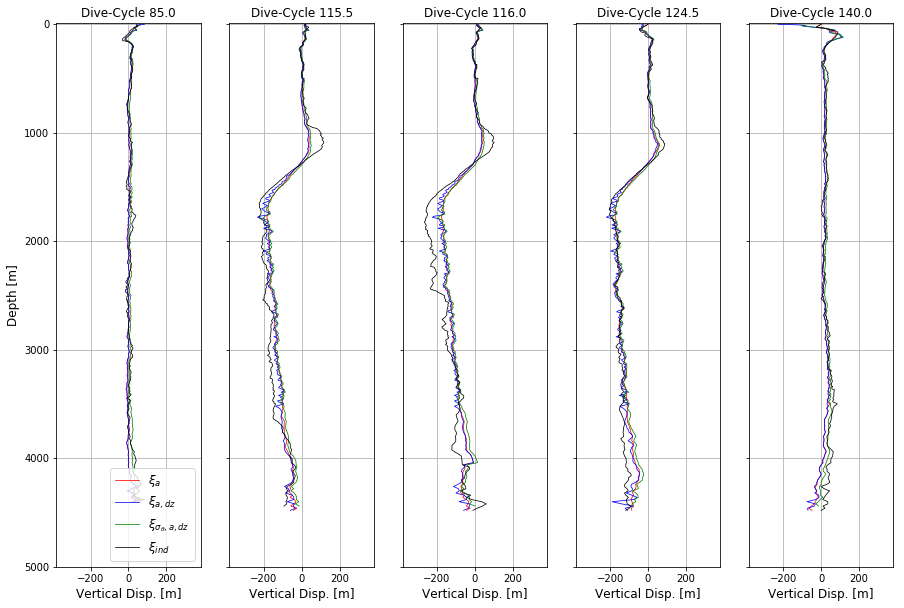

()

In [4]:
these_profiles = np.array([85, 115.5, 116, 124.5, 140])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([67, 68, 69, 70, 71])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([72, 72.5, 73, 73.5, 74])  # dive numbers of profiles to compare (individual dives)

plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    avg_rel = mw_prof_good == these_profiles[i]
    ax[i].plot(mw_eta_3_good[:, avg_rel], grid, color='r', linewidth=0.75, label=r'$\xi_a$')  # avg direct search, gamma
    ax[i].plot(-1 * mw_eta_1_good[:, avg_rel], grid, color='b', linewidth=0.75, label=r'$\xi_{a,dz}$')  # avg divide by ddz, gamma
    ax[i].plot(-1 * mw_eta_2_good[:, avg_rel], grid, color='g', linewidth=0.75, label=r'$\xi_{\sigma_{\theta},a,dz}$')  # avg divide by ddz, pot den, local pref
    ax[i].plot(eta_ind_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\xi_{ind}$')  # individual profiles direct search, gamma    
    ax[i].set_xlim([-380, 380])
    ax[i].set_title('Dive-Cycle ' + str(these_profiles[i]))
    ax[i].set_xlabel('Vertical Disp. [m]', fontsize=12)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=12, loc=4)
ax[0].set_ylabel('Depth [m]', fontsize=12)
ax[0].set_ylim([-10, 5000])
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


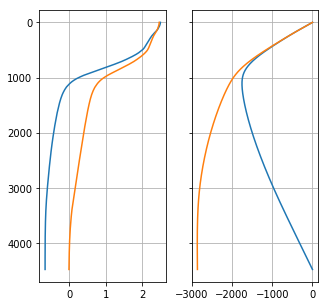

()

In [34]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
G_0, Gz_0, c_0, epsilon_0 = vertical_modes(np.nanmean(N2, axis=1), grid, omega, mmax)  # no seasons
Gs = [G_0]
Gzs = [Gz_0]
cs = [c_0]
epsilons = [epsilon_0]
# test using average over entire year
N2_tot = np.nanmean(N2, axis=1)
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(N2_tot, grid, omega, mmax)  # N2

# --- compute alternate vertical modes (allowing for a sloping bottom)
bc_bot = 1  # 1 = flat, 2 = rough
slope = 5.0*10**(-2)
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, np.nanmean(N2, axis=1))
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot, ref_lat, slope)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

plt.rcParams['figure.figsize'] = 5, 5
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(Gz_tot[:, 1], grid)
ax1.plot(F[:, 1], grid)
ax2.plot(G_tot[:, 1], grid)
ax2.plot(F_int[:, 1], grid)
ax1.grid()
ax1.invert_yaxis()
plot_pro(ax2)

In [35]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(mw_eta_3_good)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    G = G_0
    Gz = Gz_0
    c = c_0
    this_N2 = np.nanmean(N2, axis=1)

    # fit to velocity profiles
    this_V = mw_v_good[:, i].copy() # SELECT V HERE 
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        HKE_per_mass[:, i] = (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = mw_eta_3_good[:, i].copy()  # SELECT ETA HERE 
    # obtain matrix of NEta
    Neta[:, i] = this_N2 * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = this_eta.copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])        
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = this_N2 * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy
# end loop over each v and eta for fitting

In [46]:
np.shape(V_m)

(450, 42)

In [50]:
# --- check on mode amplitudes from averaging or individual profiles
mw_time_ordered_i = np.argsort(mw_time_good)
AG_ordered = AG[:, mw_time_ordered_i]
AGz_ordered = AGz[:, mw_time_ordered_i]
Time_ordered = mw_time_good[mw_time_ordered_i]
HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
Info3 = mw_prof_good[mw_time_ordered_i]
V_ordered = mw_v_good[:, mw_time_ordered_i]
Vm_ordered = V_m[:, mw_time_ordered_i]
Eta_ordered = mw_eta_3_good[:, mw_time_ordered_i]  #SELECT ETA AGAIN HERE 
Etam_ordered = Eta_m[:, mw_time_ordered_i]

# make backgrounds now just summer winter
# Summer = June 1 - Sept 15
d_main = np.where((Info3 < 102) | (Info3 > 116) & (Info3 < 122) | (Info3 > 130))[0]
# Eddy
d_eddy = np.where((Info3 >= 107) & (Info3 <= 116) | (Info3 >= 122) & (Info3 <= 130) )[0]
# combine
bckgrds = [d_main, d_eddy]  # KEY!! 4, sets of profiles
bckgrds_eta_key = 'Isopycnal Vertical Displacement', 'Eddy Displacements'
bckgrds_v_key = 'Geostrophic Velocity', 'Eddy Velocities'

In [37]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_0 = HKE_per_mass.copy()
PE_per_mass_0 = PE_per_mass.copy()
# HKE_per_mass = HKE_per_mass[:, np.where(good_ke_prof > 0)[0]]
# PE_per_mass = PE_per_mass[:, np.where(good_ke_prof > 0)[0]]
calmer = np.where((mw_prof_good < 60) | (mw_prof_good >= 71) & (good_ke_prof > 0))[0]  # excl. labby
# calmer = np.arange(0, np.int(np.sum(good_ke_prof)))
avg_PE = np.nanmean(PE_per_mass[:, calmer], 1)
avg_KE = np.nanmean(HKE_per_mass[:, calmer], 1)
# --- eddy kinetic and potential energy
ed_in = np.where((mw_prof_good > 107) & (mw_prof_good < 130))[0]
PE_ed = np.nanmean(PE_per_mass[:, ed_in[0]:ed_in[-1]], axis=1)
KE_ed = np.nanmean(HKE_per_mass[:, ed_in[0]:ed_in[-1]], axis=1)

# --- ENERGY parameters ---
vert_wavenumber = f_ref / c[1:]
dk_ke = 1000 * f_ref / c[1]
k_h = 1e3 * (f_ref / c[1:]) * np.sqrt(avg_KE[1:] / avg_PE[1:])
PE_SD, PE_GM, GMPE, GMKE = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(N2_tot)), f_ref)
vert_wave = sc_x / 1000
alpha = 10
mu = 1.88e-3 / (1 + 0.03222 * np.nanmean(theta_avg, axis=1) +
                0.002377 * np.nanmean(theta_avg, axis=1) * np.nanmean(theta_avg, axis=1))
nu = mu / gsw.rho(np.nanmean(sa_avg, axis=1), np.nanmean(ct_avg, axis=1), grid_p)
avg_nu = np.nanmean(nu)


# --- most and least energetic profiles
KE_i = HKE_per_mass[:, calmer]
PE_i = PE_per_mass[:, calmer]
KE_it = np.nan * np.ones(KE_i.shape[1])
PE_it = np.nan * np.ones(KE_i.shape[1])
for i in range(KE_i.shape[1]):
    KE_it[i] = np.trapz(KE_i[1:, i] + PE_i[1:, i], 1000 * f_ref / c[1:])
    PE_it[i] = np.trapz(PE_i[1:, i], 1000 * f_ref / c[1:])
KE_i_max = np.where(KE_it == np.nanmax(KE_it))[0]
KE_i_min = np.where(KE_it == np.nanmin(KE_it))[0]
PE_i_max = np.where(PE_it == np.nanmax(PE_it))[0]
PE_i_min = np.where(PE_it == np.nanmin(PE_it))[0]
k_h_max = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_max]) / np.squeeze(PE_i[1:, KE_i_max]))
k_h_min = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_min]) / np.squeeze(PE_i[1:, KE_i_min]))

In [38]:
# --- LOAD in Comparison DATA ---
# --- load in Station BATs PE Comparison ---
pkl_file = open('/Users/jake/Desktop/bats/station_bats_pe_jan30.pkl', 'rb')  # update jan 2019
SB = pickle.load(pkl_file)
pkl_file.close()
sta_bats_pe = SB['PE_by_season']
sta_bats_c = SB['c']
sta_bats_depth = SB['depth']
sta_bats_f = np.pi * np.sin(np.deg2rad(31.6)) / (12 * 1800)
sta_bats_dk = sta_bats_f / sta_bats_c[1]
sta_bats_pe_total = np.nanmean(np.concatenate((np.nanmean(sta_bats_pe[0], axis=1)[:, None],
                                    np.nanmean(sta_bats_pe[1], axis=1)[:, None],
                                    np.nanmean(sta_bats_pe[2], axis=1)[:, None]), axis=1), axis=1)
sta_bats_n2_1 = SB['N2_per_season'][:, 1]
PE_SD_bats, PE_GM_bats, GMPE_bats, GMKE_bats = PE_Tide_GM(rho0, sta_bats_depth,
                                                          len(sta_bats_pe_total), sta_bats_n2_1[:, None], sta_bats_f)

# seasonal and variable spread at bats station for each mode
sta_max = np.nan * np.ones(len(sc_x))
sta_min = np.nan * np.ones(len(sc_x))
dg_per_max = np.nan * np.ones(len(sc_x))
dg_per_min = np.nan * np.ones(len(sc_x))
for i in range(1, mmax+1):
    test1 = np.nanmean(sta_bats_pe[0][i, :])
    test2 = np.nanmean(sta_bats_pe[1][i, :])
    test3 = np.nanmean(sta_bats_pe[2][i, :])
    # test4 = np.nanmean(sta_bats_pe[3][i, :])
    sta_max[i - 1] = np.max([test1, test2, test3])
    sta_min[i - 1] = np.min([test1, test2, test3])
    dg_per_max[i - 1] = np.nanmax(PE_per_prof[i, :])
    dg_per_min[i - 1] = np.nanmin(PE_per_prof[i, :])

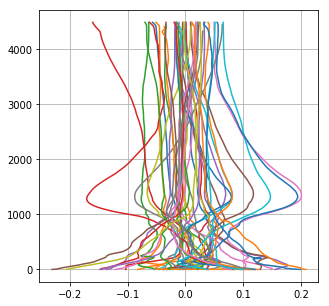

()

In [47]:
f, ax = plt.subplots()
for i in range(len(V_ordered[10, :])):
    ax.plot(V_ordered[:, i], grid)
plot_pro(ax)

In [51]:
# --- glider v           
grid_check_i = range(5, len(grid)-10)
grid_check = grid[grid_check_i]
Vzq0 = V_ordered[grid_check_i, :].copy()
Vzq = Vzq0[:, bckgrds[0]]
nq_v = np.size(Vzq[0, :])
avg_Vzq = np.nanmean(np.transpose(Vzq), axis=0)
data_V = Vzq - np.transpose(np.tile(avg_Vzq, [nq_v, 1]))
[UU, SS, VV] = np.linalg.svd(data_V, full_matrices=False, compute_uv=True)

p2 = np.min([np.shape(data_V)[0], np.shape(data_V)[1]])
Sp2=SS2[0:p2];
lamb2=np.matrix(Sp2[:, None])*np.transpose(np.matrix(Sp2[:, None]));
var_v=np.trace(lamb2);
frac_eof=np.diag(lamb2)/var_v;

# --- glider v           
grid_check_i = range(5, len(grid)-10)
grid_check = grid[grid_check_i]
Vzq = V_ordered[grid_check_i, :].copy()
Vzq = Vzq[:, bckgrds[1]]
nq_v = np.size(Vzq[0, :])
avg_Vzq = np.nanmean(np.transpose(Vzq), axis=0)
data_V = Vzq - np.transpose(np.tile(avg_Vzq, [nq_v, 1]))
[UU_ed, SS_ed, VV_ed] = np.linalg.svd(data_V, full_matrices=False, compute_uv=True)

p2 = np.min([np.shape(data_V)[0], np.shape(data_V)[1]])
Sp2=SS2[0:p2];
lamb2=np.matrix(Sp2[:, None])*np.transpose(np.matrix(Sp2[:, None]));
var_v=np.trace(lamb2);
frac_eof_ed=np.diag(lamb2)/var_v;

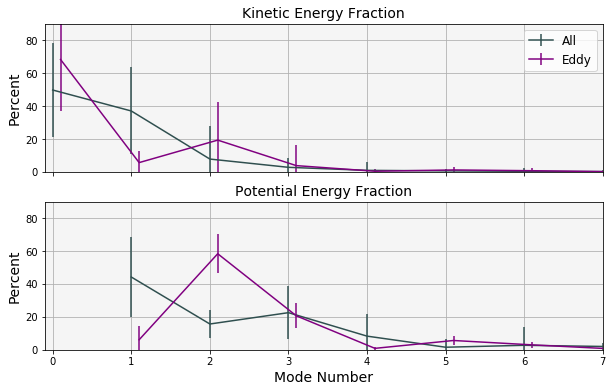

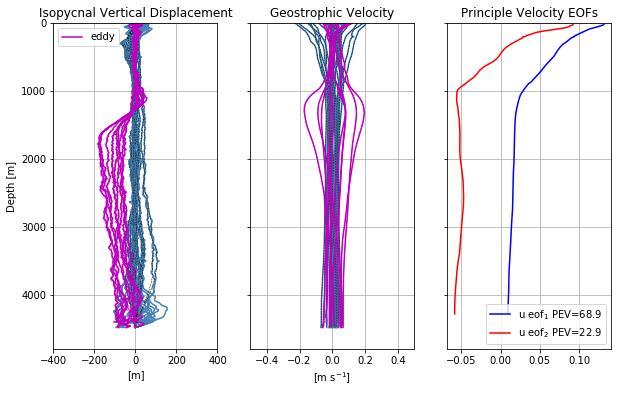

In [52]:
# --- Partition KE, PE by season (like bats) ---

k_h_m = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
k_h_eddy = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))

# --- RATIO of KE_i / KE_total
KE_fraction_m_t = 100 * HKE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[0]],
                                                                         axis=0), (nmodes, 1))
KE_m_std = np.nanstd(KE_fraction_m_t, axis=1)
KE_fraction_ed_t = 100 * HKE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[1]],
                                                                        axis=0), (nmodes, 1))
KE_ed_std = np.nanstd(KE_fraction_ed_t, axis=1)

KE_fraction_m = 100 * np.nanmean(HKE_per_mass_0[:, bckgrds[0]], 
                            axis=1) / np.nansum(np.nanmean(HKE_per_mass_0[:, bckgrds[0]], axis=1))
KE_fraction_ed = 100 * np.nanmean(HKE_per_mass_0[:, bckgrds[1]], 
                            axis=1) / np.nansum(np.nanmean(HKE_per_mass_0[:, bckgrds[1]], axis=1))

# fraction PE partition for each profile 
PE_fraction_m_t = 100 * PE_per_mass_0[1:, bckgrds[0]] / np.tile(np.nansum(PE_per_mass_0[1:, bckgrds[0]],
                                                                        axis=0), (nmodes - 1, 1))
PE_m_std = np.nanstd(PE_fraction_m_t, axis=1)
PE_fraction_ed_t = 100 * PE_per_mass_0[1:, bckgrds[1]] / np.tile(np.nansum(PE_per_mass_0[1:, bckgrds[1]],
                                                                       axis=0), (nmodes - 1, 1))
PE_ed_std = np.nanstd(PE_fraction_ed_t, axis=1)

# fraction PE partition for avg profile 
PE_fraction_m = 100 * np.nanmean(PE_per_mass_0[1:, bckgrds[0]], 
                            axis=1) / np.nansum(np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
PE_fraction_ed = 100 * np.nanmean(PE_per_mass_0[1:, bckgrds[1]], 
                            axis=1) / np.nansum(np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))
    
cols = ['#2F4F4F', '#800080', '#FF4500', '#DAA520',]
matplotlib.rcParams['figure.figsize'] = (10,6)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_facecolor('#F5F5F5')
ax1.errorbar(np.arange(0, nmodes), KE_fraction_m, yerr=KE_m_std, color=cols[0], label='All')
ax1.errorbar(np.arange(0, nmodes) + .1, KE_fraction_ed, yerr=KE_ed_std, color=cols[1], label='Eddy')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12)
ax1.set_ylim([0, 90])
ax1.set_xlim([-.1, 7])
ax1.set_title('Kinetic Energy Fraction', fontsize=14)
ax1.set_ylabel('Percent', fontsize=14)
ax1.grid()
ax2.set_facecolor('#F5F5F5')
ax2.errorbar(np.arange(1, nmodes), PE_fraction_m, yerr=PE_m_std, color=cols[0])
ax2.errorbar(np.arange(1, nmodes) + .1, PE_fraction_ed, yerr=PE_ed_std, color=cols[1])
# ax2.errorbar(np.arange(1, nmodes), np.nanmean(PE_fraction_w1, axis=1), yerr=np.nanstd(PE_fraction_w1, axis=1), color=cols[0])
# ax2.errorbar(np.arange(1, nmodes) + .1, np.nanmean(PE_fraction_s, axis=1), yerr=np.nanstd(PE_fraction_s, axis=1), color=cols[1])
# ax2.errorbar(np.arange(1, nmodes) + .2, np.nanmean(PE_fraction_w2, axis=1), yerr=np.nanstd(PE_fraction_w2, axis=1), color=cols[2])
ax2.set_ylim([0, 90])
ax2.set_title('Potential Energy Fraction', fontsize=14)
ax2.set_ylabel('Percent', fontsize=14)
ax2.set_xlabel('Mode Number', fontsize=14)
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_14_energy_fracs.jpg", dpi=300)

# velocity profiles by season 
f, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True)
vin = Eta_ordered[:, bckgrds[0]]
vin_m = Etam_ordered[:, bckgrds[0]]
for j in range(np.shape(V_ordered[:, bckgrds[0]])[1]):
    ax0.plot(vin[:, j], grid, color='#4682B4')
    ax0.plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
vin = Eta_ordered[:, bckgrds[1]]
vin_m = Etam_ordered[:, bckgrds[1]]
for j in range(np.shape(V_ordered[:, bckgrds[1]])[1]):
    ax0.plot(vin[:, j], grid, color='m')
    ax0.plot(vin_m[:, j], grid, linestyle='--', color='m', linewidth=0.5)
ax0.plot(vin[:, 0], grid, color='m', label='eddy')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=10)
    
vin = V_ordered[:, bckgrds[0]]
vin_m = Vm_ordered[:, bckgrds[0]]
for j in range(np.shape(V_ordered[:, bckgrds[0]])[1]):
    ax1.plot(vin[:, j], grid, color='#4682B4')
    ax1.plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
vin = V_ordered[:, bckgrds[1]]
vin_m = Vm_ordered[:, bckgrds[1]]
for j in range(np.shape(V_ordered[:, bckgrds[1]])[1]):
    ax1.plot(vin[:, j], grid, color='m')
    ax1.plot(vin_m[:, j], grid, linestyle='--', color='m', linewidth=0.5)  

ax2.plot(UU[:, 0], grid_check, label=r'u eof$_1$ PEV=' + str(np.round(frac_eof[0]*100,1)), color='b')
ax2.plot(UU[:, 1], grid_check, linestyle='-', label=r'u eof$_2$ PEV=' + str(np.round(frac_eof[1]*100,1)), color='r') 
# ax2.plot(UU_ed[:, 0], grid_check, linestyle='--', label=r'u eof$_1$ PEV=' + str(np.round(frac_eof_ed[0]*100,1)), color='b')
# ax2.plot(UU_ed[:, 1], grid_check, linestyle='--', label=r'u eof$_2$ PEV=' + str(np.round(frac_eof_ed[1]*100,1)), color='r') 
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=10)

ax0.set_ylim([0, 4800])
ax0.invert_yaxis()    
ax0.set_xlim([-400, 400])
ax1.set_xlim([-0.5, 0.5])
ax0.set_title('Isopycnal Vertical Displacement')
ax1.set_title('Geostrophic Velocity')
ax2.set_title('Principle Velocity EOFs')
ax0.set_ylabel('Depth [m]')    
ax0.set_xlabel(r'[m]')
ax1.set_xlabel(r'[m s$^{-1}$]')
ax0.grid()
ax1.grid()
plot_pro(ax2)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_14_v_eta_eof.jpg", dpi=300)

# displacement profiles by season 
# f, ax = plt.subplots(1, len(bckgrds), sharey=True)
# for i in range(len(bckgrds)):
#     vin = Eta_ordered[:, bckgrds[i]]
#     vin_m = Etam_ordered[:, bckgrds[i]]
#     for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
#         ax[i].plot(vin[:, j], grid)
#         ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
#     ax[i].set_xlim([-350, 350])
#     ax[i].set_title(bckgrds_eta_key[i])
# ax[0].set_ylabel('Depth [m]')
# ax[0].set_xlabel('[m]')
# ax[1].set_xlabel('[m]')
# ax[0].set_ylim([0, 4800])
# ax[0].grid()
# ax[0].invert_yaxis()
# plot_pro(ax[1])
# f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/dg_bats_14_eta_seasonal.jpg", dpi=300)

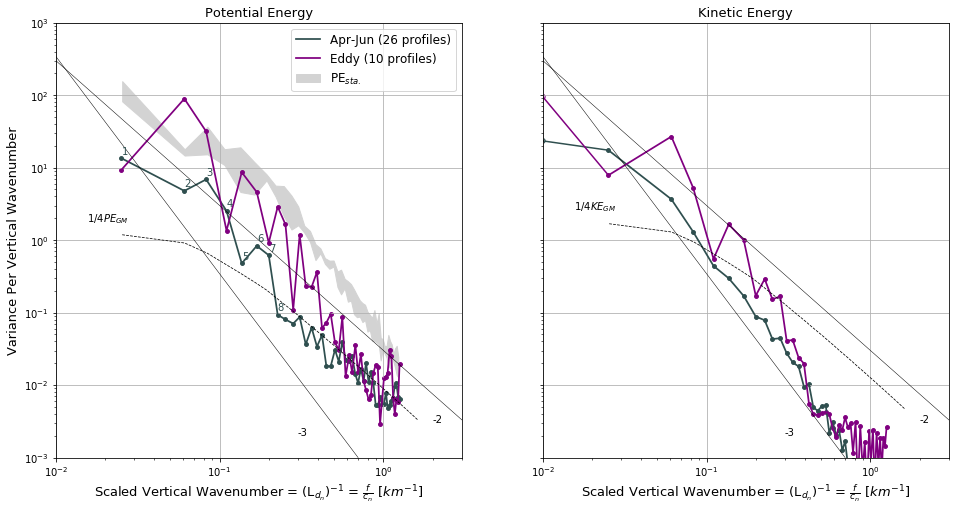

()

In [20]:
# --- PLOT ENERGY BY SEASON

matplotlib.rcParams['figure.figsize'] = (16,8)

f_s_en, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
labs = 'Apr-Jun (' + str(np.shape(d_main)[0]) + ' profiles)', 'Eddy (' + str(np.shape(d_eddy)[0]) + ' profiles)'
ax1.fill_between(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], sta_min / sta_bats_dk, sta_max / sta_bats_dk,
                 label='PE$_{sta.}$', color='#D3D3D3')
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds)))
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax2.scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0:2] / dk, color=cols[i], linewidth=1.5)
    ax2.scatter(10**-2, np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk, color=cols[i], s=scz[i]*1.5, facecolors='none')
    seasonal_PE_output[1:, i] = np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[1:, i] = np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[0, i] = np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk
modeno = '1', '2', '3', '4', '5', '6', '7', '8'   
for i in range(len(modeno)):
    ax1.text(sc_x[i], (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk) + 
             (np.nanmean(PE_per_mass_0[i + 1, bckgrds[0]]) / dk)/7, modeno[i], color=cols[0])    
# -- GM
ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * PE_GM_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * PE_GM_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)
ax2.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMKE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
ax2.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMKE_bats[1] / sta_bats_dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax2.text(2*10**0, 3*10**-3, '-2', fontsize=10)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=13)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=13)
ax1.set_title('Potential Energy', fontsize=13)
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=13)
ax2.set_title('Kinetic Energy', fontsize=13)
ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
ax2.set_xscale('log')
ax1.grid()
plot_pro(ax2)
# f_s_en.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_04_18/dg_bats_energy_seasons.jpg", dpi=300)

In [21]:
PE_SD, PE_GM, GMPE, GMKE = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(N2_tot)), f_ref)

sa = 1
if sa > 0:
    my_dict = {'depth': grid, 'c': c, 'f': f_ref, 'N2': N2_tot,
               'PE_all': PE_per_mass_0, 'KE_all': HKE_per_mass_0, 
               'GMPE': GMPE, 'GMKE': GMKE,
               'epsilons': epsilon_0, 'indices': bckgrds}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2014_energy_oct_4_2019.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()

In [12]:
np.shape(N2)

(450, 4)